# Simple app to predict differential prices using 3 models


## push Appmode to run the app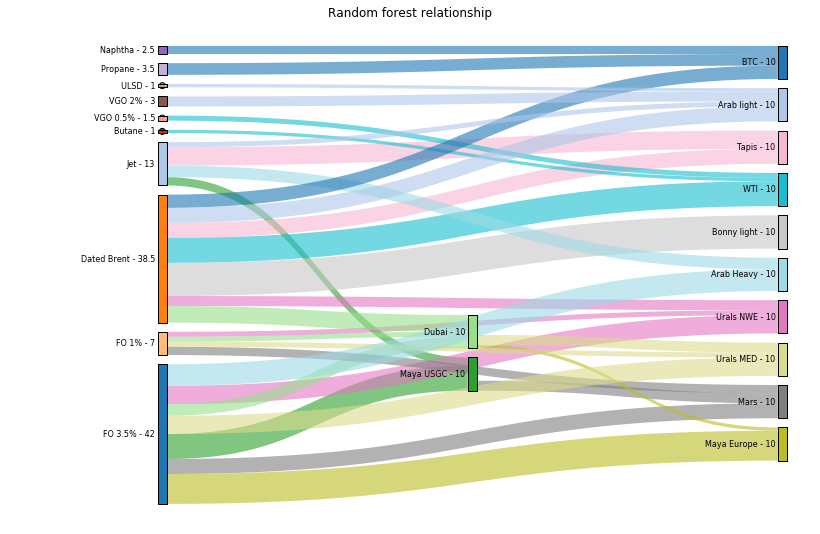

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.ensemble import RandomForestRegressor
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.api as sm

combi = pd.read_table('Historical_combi2.csv',delimiter =';')

import datetime
datetimes = [datetime.datetime.strptime(d, '%d.%m.%Y') for d in combi["Date"]]


df = pd.DataFrame(datetimes, columns=['date'])
df.loc[:, 'date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
combi = combi.assign(df=df['date'].values)



def plotdiag(combi,model):
    
    model = model.replace("_", " ")
    plt.rcParams['figure.dpi'] = 100
    rma60 = combi[model].rolling(window=60).mean()
    ema60 = combi[model].ewm(span=60, adjust=False).mean()
    plt.plot(combi["df"],combi[model])
    plt.plot(combi["df"],rma60)
    plt.plot(combi["df"],ema60)
    plt.legend(("Monthly","rma","ema"))
    plt.show()
    return

def regressionlinear(X,Y):
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    #print('Intercept: \n', regr.intercept_)
    #print('Coefficients: \n', regr.coef_)

    X = sm.add_constant(X.to_numpy())
    model = sm.OLS(Y, X).fit()
    predictions = model.predict(X) 
 
    print_model = model.summary()
    #print(print_model)
    
    return regr.intercept_,regr.coef_



def randomforest(x_train,y_train,x_test,y_test):
    
    plt.rcParams['figure.dpi'] = 100

    regressor = RandomForestRegressor(n_estimators=200, max_depth=5)
    clf=regressor.fit(x_train, y_train)

    y_pred=regressor.predict(x_test)
    y_pred=pd.DataFrame(y_pred)


    plt_train=plt.scatter(x_train.iloc[:,0],y_train,   color='grey')
    plt_test=plt.scatter(x_test.iloc[:,0],y_test,   color='green')
    plt_pred=plt.scatter(x_test.iloc[:,0], y_pred,  color='black')

    plt.xlabel(x_test.columns[0])
    plt.ylabel(y_test.columns[0])
    plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
    plt.show()

    print("Mean squared error: %.2f" % np.mean((regressor.predict(x_train) - y_train) ** 2))

    import seaborn as sns
    importances=regressor.feature_importances_

    indices=list(x_train)
    print("Feature ranking:")
    
    for f in range(x_train.shape[1]):
        print("Feature %s (%f)" % (indices[f], importances[f]))

    f, (ax1) = plt.subplots(1, 1, figsize=(6, 4), sharex=True)
    sns.barplot(indices, importances, palette="BrBG", ax=ax1)
    ax1.set_ylabel("Importance")

    ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
    );

    return regressor.predict



@interact(DB=(0,200),FO35=(-50,10),FO1=(-30,10),Jet=(0,50),ULSD=(0,50),
          Bu=(-65,10),VGO05=(-20,20),Po=(-65,10),Na=(-30,20),
          model=['Bonny_light', 'Urals_NWE','Tapis','Maya_USGC','WTI','Dubai','Azeri_BTC'])

      
def NPV_Calc(DB,FO35,FO1,Jet,ULSD,Bu,VGO05,Po,Na,model):
    
    Bonny_light  ={'input': 'DB'}
    Urals_NWE  ={'input': 'DB'}
    
    if model == 'Bonny_light':
             
        plotdiag(combi,model)
                
        print(model)
        
        #Non linear model
        nonlinear_BL = 0.0164924882990988*(DB) + 4.43302177278368e-5*np.power(DB,2) - 0.157317431833725
        #print("Non.linear predicted price =[", nonlinear_BL,"]")
        
        #Linear model
        Y = combi[['Bonny light']].dropna()
        K=list(Y.index.values)
        K[0]
        X = combi[['Dated Brent']].iloc[K[0]:]
        #print(X)
        #print(Y)
        intercept_, coef_ = regressionlinear(X,Y)
        linear_BL=intercept_+ coef_[0]*DB 
        #print("Linear predicted price =", linear_BL)
        
        #Random forest
               
        All = pd.concat([X,Y],axis=1,sort=False)
        train = All.iloc[:,:]
        test =All.iloc[-100:,:]
        
        x_train=train["Dated Brent"].to_frame()
        y_train=train["Bonny light"]
        
        x_test=test["Dated Brent"].to_frame()
        y_test=test["Bonny light"].to_frame()
        F=randomforest(x_train,y_train,x_test,y_test)
        

        invar = {'Dated Brent':[DB]}
        invar_df = pd.DataFrame(invar)
        y_pred = F(invar_df)
        
                
        print("Linear predicted price =", linear_BL)
        print("Non.linear predicted price =[", nonlinear_BL,"]")
        print("Random forest price =",y_pred)
        
        
    elif model == 'Urals_NWE':
        
        plotdiag(combi,model)
                
        #Non linear model
        nonlinear_UralN = 0.243310947652501*(FO35) + 0.0327070285007665*(DB) 
        +0.000931100809264595*np.power(FO1,3) + 3.01672677408283e-5*np.power(FO1,4) 
        -0.771156577782479 - 0.00241982760220774*(DB)*(FO1) - 0.000191940652210639*np.power(DB,2)
                
        #Linear model
        Y = combi[['Urals NWE']].dropna()
        K=list(Y.index.values)
        K[0]
        X = combi[['Dated Brent','FO 3.5%','FO 1%']].iloc[K[0]:]
               
        intercept_, coef_ = regressionlinear(X,Y)
        coef_ = coef_.reshape(-1)
        linear_UralN=intercept_+ coef_[0]*DB + coef_[1]*FO35 + coef_[2]*FO1
                
        #Random forest
               
        All = pd.concat([X,Y],axis=1,sort=False)
        train = All.iloc[-100:,:]
        test =All.iloc[:-100,:]
        
        x_train=train[["Dated Brent","FO 3.5%","FO 1%"]]
        y_train=train["Urals NWE"]
        
        x_test=test[["Dated Brent","FO 3.5%","FO 1%"]]
        y_test=test["Urals NWE"].to_frame()
        F=randomforest(x_train,y_train,x_test,y_test)
        

        invar = {'Dated Brent':[DB], 'FO 3.5%':[FO35], 'FO 1%':[FO1]}
        invar_df = pd.DataFrame(invar)
        y_pred = F(invar_df)
        
                
        print("Linear predicted price =", linear_UralN)
        print("Non.linear predicted price =[", nonlinear_UralN,"]")
        print("Random forest price =",y_pred)
        
    elif model == 'Tapis':    
        
        plotdiag(combi,model)
        
        #Non linear model
        nonlinear_Tapis = 0.569028548370371 + 0.158148187922098*Jet + 1.72847337855664e-6*np.power(DB,3)
        + 0.000198531291135097*Jet*np.power(ULSD,2) - 0.000213781975514373*np.power(ULSD,3)
        
        #Linear model
        Y = combi[['Tapis']].dropna()
        K=list(Y.index.values)
        K[0]
        X = combi[['Dated Brent','Jet','ULSD']].iloc[K[0]:]
        X = X.fillna(0)       
        intercept_, coef_ = regressionlinear(X,Y)
        coef_ = coef_.reshape(-1)
        linear_Tapis=intercept_+ coef_[0]*DB + coef_[1]*Jet + coef_[2]*ULSD
        
        #Random forest
               
        All = pd.concat([X,Y],axis=1,sort=False)
        train = All.iloc[-100:,:]
        test =All.iloc[:-100,:]
        
        x_train=train[["Dated Brent","Jet","ULSD"]]
        y_train=train["Tapis"]
        
        x_test=test[["Dated Brent","Jet","ULSD"]]
        y_test=test["Tapis"].to_frame()
        F=randomforest(x_train,y_train,x_test,y_test)
        

        invar = {'Dated Brent':[DB], 'Jet':[Jet], 'ULSD':[ULSD]}
        invar_df = pd.DataFrame(invar)
        y_pred = F(invar_df)
        print("Linear predicted price =", linear_Tapis)
        print("Non.linear predicted price =[", nonlinear_Tapis,"]")
        print("Random forest price =",y_pred)
        
        
    elif model == 'WTI':
        
        plotdiag(combi,model)
        
        #Non linear model
        nonlinear_WTI = -15.142388486653 - 2.06420352656404*Bu - 0.00877784990583735*DB*VGO05
        - 0.000867998048676867*np.power(Bu,3) - 0.0803378779475392*np.power(Bu,2)
        
        #Linear model
        Y = combi[['WTI']].dropna()
        K=list(Y.index.values)
        K[0]
        X = combi[['Dated Brent','Butane','VGO 0.5%']].iloc[K[0]:]
        X = X.fillna(0)       
        intercept_, coef_ = regressionlinear(X,Y)
        coef_ = coef_.reshape(-1)
        linear_WTI=intercept_+ coef_[0]*DB + coef_[1]*Bu + coef_[2]*VGO05
        
        #Random forest
        All = pd.concat([X,Y],axis=1,sort=False)
        train = All.iloc[-80:,:]
        test =All.iloc[:80,:]
        
        x_train=train[["Dated Brent","Butane","VGO 0.5%"]]
        y_train=train["WTI"]
        
        x_test=test[["Dated Brent","Butane","VGO 0.5%"]]
        y_test=test["WTI"].to_frame()
        F=randomforest(x_train,y_train,x_test,y_test)
        

        invar = {'Dated Brent':[DB], 'Butane':[Bu], 'VGO 0.5%':[VGO05]}
        invar_df = pd.DataFrame(invar)
        y_pred = F(invar_df)
        print("Linear predicted price =", linear_WTI)
        print("Non.linear predicted price =[", nonlinear_WTI,"]")
        print("Random forest price =",y_pred)
        
        
    elif model == 'Maya_USGC':   
        
        plotdiag(combi,model)
        
        #nonlinear model
        nonlinear_MayaU =  0.687587246470687*FO35 + 0.00911247235417213*np.power(Jet,2) 
        + 0.0036123829112612*np.power(FO35,2) - 0.242991626831371*Jet

        #Linear model
        Y = combi[['Maya USGC']].dropna()
        K=list(Y.index.values)
        K[0]
        X = combi[['Dated Brent','FO 3.5%','Jet']].iloc[K[0]:]
        X = X.fillna(0)       
        intercept_, coef_ = regressionlinear(X,Y)
        coef_ = coef_.reshape(-1)
        linear_MayaU=intercept_+ coef_[0]*DB + coef_[1]*FO35 + coef_[2]*Jet
        
        #Random forest
        All = pd.concat([X,Y],axis=1,sort=False)
        train = All.iloc[:,:]
        test =All.iloc[:-100,:]
        
        x_train=train[["Dated Brent","FO 3.5%","Jet"]]
        y_train=train["Maya USGC"]
        
        x_test=test[["Dated Brent","FO 3.5%","Jet"]]
        y_test=test["Maya USGC"].to_frame()
        F=randomforest(x_train,y_train,x_test,y_test)
        

        invar = {'Dated Brent':[DB], 'FO 3.5%':[FO35], 'Jet':[Jet]}
        invar_df = pd.DataFrame(invar)
        y_pred = F(invar_df)
        print("Linear predicted price =", linear_MayaU)
        print("Non.linear predicted price =[", nonlinear_MayaU,"]")
        print("Random forest price =",y_pred)
        
        
    elif model == 'Dubai':
        
        plotdiag(combi,model)
        
        #nonlinear model
        nonlinear_Dubai = 0.231614617140716*(FO35) + 0.0567664299088329*(DB) 
        + 0.000111685887466789*(DB)*np.power(FO35,2) - 1.13165773385408 
        - 3.92742103073686e-6*np.power(DB,3) - 0.0101251631604449*np.power(FO35,2)
        
        #Linear model
        Y = combi[['Dubai']].dropna()
        K=list(Y.index.values)
        K[0]
        X = combi[['Dated Brent','FO 3.5%','FO 1%']].iloc[K[0]:]
        X = X.fillna(0)       
        intercept_, coef_ = regressionlinear(X,Y)
        coef_ = coef_.reshape(-1)
        linear_Dubai=intercept_+ coef_[0]*DB + coef_[1]*FO35 + coef_[2]*FO1
        
        #Random forest
        All = pd.concat([X,Y],axis=1,sort=False)
        train = All.iloc[-100:,:]
        test =All.iloc[:-100:]
        
        x_train=train[["Dated Brent","FO 3.5%","FO 1%"]]
        y_train=train["Dubai"]
        
        x_test=test[["Dated Brent","FO 3.5%","FO 1%"]]
        y_test=test["Dubai"].to_frame()
        F=randomforest(x_train,y_train,x_test,y_test)
        

        invar = {'Dated Brent':[DB], 'FO 3.5%':[FO35], 'FO 1%':[FO1]}
        invar_df = pd.DataFrame(invar)
        y_pred = F(invar_df)
        print("Linear predicted price =", linear_Dubai)
        print("Non.linear predicted price =[", nonlinear_Dubai,"]")
        print("Random forest price =",y_pred)
    
    elif model == 'Azeri_BTC':
        
        plt.rcParams['figure.dpi'] = 100
        rma60 = combi["Azeri BTC"].rolling(window=60).mean()
        ema60 = combi["Azeri BTC"].ewm(span=60, adjust=False).mean()
        plt.plot(combi["df"],combi["Azeri BTC"])
        plt.plot(combi["df"],rma60)
        plt.plot(combi["df"],ema60)
        plt.legend(("Monthly","rma","ema"))
        plt.show()
        #Nonlinear model
        nonlinear_BTC = 2 - 0.0186675105114445*DB*np.exp(-7.82878945629328e-9*Po*Na*np.power(DB,3))
        #linear model
        Y = combi[['Azeri BTC']].dropna()
        K=list(Y.index.values)
        K[0]
        X = combi[['Dated Brent','Propane','Naphtha']].iloc[K[0]:]
        X = X.fillna(0)       
        intercept_, coef_ = regressionlinear(X,Y)
        coef_ = coef_.reshape(-1)
        linear_BTC=intercept_+ coef_[0]*DB + coef_[1]*Po + coef_[2]*Na
        
        #Random forest
        All = pd.concat([X,Y],axis=1,sort=False)
        train = All.iloc[:-50,:]
        test =All.iloc[-100:,:]
        
        x_train=train[["Dated Brent","Propane","Naphtha"]]
        y_train=train["Azeri BTC"]
        
        x_test=test[["Dated Brent","Propane","Naphtha"]]
        y_test=test["Azeri BTC"].to_frame()
        F=randomforest(x_train,y_train,x_test,y_test)
        

        invar = {'Dated Brent':[DB], 'Propane':[Po], 'Naphtha':[Na]}
        invar_df = pd.DataFrame(invar)
        y_pred = F(invar_df)
        print("Linear predicted price =", linear_BTC)
        print("Non.linear predicted price =[", nonlinear_BTC,"]")
        print("Random forest price =",y_pred)
    
        
    else:
        print('choose something from drop down menu')   

    return
    





interactive(children=(IntSlider(value=100, description='DB', max=200), IntSlider(value=-20, description='FO35'…